<a href="https://colab.research.google.com/github/himalayahall/DATA602/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

NLP (Natural Language Processing), NLU (Natural Language Understanding), and NLG (Natural Language Generation) are important subtopics of Machine 
Learning. 

**NLP** it involves programming computers to process massive volumes of language data. It involves numerous tasks that break down natural language into 
smaller elements in order to understand the relationships between those elements and how they work together. NLP focuses largely on converting text to 
structured data. It does this through the identification of named entities (a process called named entity recognition) and identification of word 
patterns, using methods like tokenization, stemming, and lemmatization, which examine the root forms of words.

**NLU** (Natural Language Understanding) is a subset of natural language processing, which uses syntactic and semantic analysis of text and speech to determine the meaning of a sentence. One of the primary goals of NLU is to teach machines how to interpret and understand language inputted by humans. 
It aims to teach computers what a body of text or spoken speech means. NLU leverages AI algorithms to recognize attributes of language such as sentiment, semantics, context, and intent. It enables computers to understand the subtleties and variations of language.

**NLG** (Natural Language Generation) is also a subset of NLP and is concerned with enabling machines to not just process and understand text but to generate text. While NLU focuses on computer reading comprehension, NLG enables computers to write. NLG is the process of producing a human language 
text response based on some data input (prompt).[[1]](#1)

## Project Goal

Recent advancements in NLP, most notable the NLG capabilities of Large Language Models (LLM) like ChatGPT, have taken the public imagination by storm. In this project we will explore the following:

- **NLP**: create a classifier to classify product reviews as either original (presumably human created and authentic) or fake (computer generated fake reviews). The motivation for using this dataset is that fake reviews are a major problem, as highlighted in the NPR article [Why we usually can't tell when a review is fake](https://www.npr.org/sections/money/2023/03/07/1160721021/why-we-usually-cant-tell-when-a-review-is-fake), and it would be great to leverage NLP to address the problem.
  - Use [Fastai](https://docs.fast.ai) to build the classifier. This will be accomplished by taking a pretrained language model and fine-tuning it to classify reviews.  What we call a language model is a model that has been trained to guess what the next word in a text is (having read the ones before). This kind of task is called self-supervised learning: we do not need to give labels to our model, just feed it lots and lots of texts. It has a process to automatically get labels from the data, and this task isn't trivial: to properly guess the next word in a sentence, the model will have to develop an understanding of the English (or other) language.[[2]](#2)
- **NLU**: the English learned by the pretrained language model (Wikipedia) is slightly different from the English used for product reviews, so instead of jumping directly to the classifier, we will fine-tune our pretrained language model to the product corpus and then use that as the base for our classifier. This should (hopefully) result in better performance.
- **NLG**: finally, having created a language model that has been fine-tuned for product reviews, we will use it to auto-generate fake reviews. This will be done by giving the model some starting text (prompt) and then asking the model to generate the rest (up to a maximum number of words).

## Data Sources

The generated [fake reviews dataset](https://osf.io/3vds7), containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.

## Tools and Frameworks

- [Google Collab](https://colab.research.google.com)
- [Jupyter Notebook](https://jupyter.org/)
- [Fastai](https://docs.fast.ai)

## References
<a id="1">[1]</a>
https://www.ibm.com/topics/natural-language-processing

<a id="2">[2]</a>
https://fastai.github.io/fastbook2e/book10.html


# Load data

In [1]:
import pandas as pd
import re

df = pd.read_csv('https://raw.githubusercontent.com/himalayahall/DATA607/main/Project4/EMAILSpamCollectionFull.csv')

In [2]:
df.head()

,id,from,subject,category,text
0,1,robert elz <kre@munnari.oz.au>,re: new sequences window,ham,"Date: Wed, 21 Aug 2002 10:54:46 -0..."
1,2,steve burt <steve_burt@cursor-system.com>,[zzzzteana] re: alexander,ham,"Martin A posted:Tassos Papadopoulos, the Gree..."
2,3,"""tim chapman"" <timc@2ubh.com>",[zzzzteana] moscow bomber,ham,Man Threatens Explosion In Moscow Thursday Au...
3,4,monty solomon <monty@roscom.com>,[irr] klez: the virus that won't die,ham,Klez: The Virus That Won't Die Already the mo...
4,5,tony nugent <tony@linuxworks.com.au>,re: insert signature,ham,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro..."


Drop all columns except text and category.

In [3]:
df.drop(columns=['from', 'subject'], inplace=True)
df

,id,category,text
0,1,ham,"Date: Wed, 21 Aug 2002 10:54:46 -0..."
1,2,ham,"Martin A posted:Tassos Papadopoulos, the Gree..."
2,3,ham,Man Threatens Explosion In Moscow Thursday Au...
3,4,ham,Klez: The Virus That Won't Die Already the mo...
4,5,ham,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro..."
...,...,...,...
9345,9346,spam,NaN
9346,9347,spam,NaN
9347,9348,spam,NaN
9348,9349,spam,NaN


In [4]:
df.describe(include='object')

,category,text
count,9350,7953
unique,2,4618
top,ham,
freq,5553,84


# Cleanup Data

Drop NAs and strip HTML tags.

In [5]:
df.dropna(inplace=True)
df['text'] = df['text'].str.replace('<[^<>]*>', ' ', regex=True)
df.head()

,id,category,text
0,1,ham,"Date: Wed, 21 Aug 2002 10:54:46 -0..."
1,2,ham,"Martin A posted:Tassos Papadopoulos, the Gree..."
2,3,ham,Man Threatens Explosion In Moscow Thursday Au...
3,4,ham,Klez: The Virus That Won't Die Already the mo...
4,5,ham,"On Wed Aug 21 2002 at 15:46, Ulises Ponce wro..."


Data summary.

In [6]:
df.describe(include='object')

,category,text
count,7953,7953
unique,2,4565
top,ham,
freq,5553,84


## Compute NULL model (baseline) accuracy

The data set is unbalanced (more ham instances than spams), and the null model has 70% accuracy. 

Any model worth considering must have greater accuracy (at a minimum) than null model

In [7]:
cat_size = df.groupby('category').size()
print(cat_size)

ham_prop = cat_size[0] / (cat_size[0] + cat_size[1])
print('Baseline (null model) accuracy: ' , ham_prop)

category
ham     5553
spam    2400
dtype: int64
Baseline (null model) accuracy:  0.6982270841192003


## Fastai

In [8]:
from fastai.data.all import *
from fastai.text.all import *

Create data loaders for classification, build **DataBlock** using **TextBlock** and **CategoryBlock**. Set aside 20% data using **TrainTestSplitter** for model testing.

In [9]:
dls_cls = DataBlock(
            blocks=(
                TextBlock.from_df(text_cols=('text'), 
                        is_lm=False),
                CategoryBlock),
            get_x=ColReader('text'), 
            get_y=ColReader('category'),
            splitter=TrainTestSplitter(test_size=0.2,stratify=df.category)
        ).dataloaders(df)

In [10]:
dls_cls.show_batch(max_n = 5)

,text,category
0,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk - mail : xxunk : 03 - 3518 - xxunk",ham
1,"xxbos i did more testing with your patch on top of today 's xxup cvs , but the xxunk help at all.the following is the results of the tests : testing xxunk . created a "" / dev / md0 "" with 4 scsi xxunk . created a xxup lvm xxmaj volume group "" vg "" with the "" / dev / xxunk . created a xxup lvm logical volume "" vol1 "" with "" xxunk . created a xxup xfs fs with a command : mkfs.xfs -f -d xxunk / dev / vg / vol1 xxrep 11 - meta - data= / dev / vg / vol1 xxunk xxunk blks xxrep 11 - data = bsize=4096 xxunk xxrep 11 - = sunit=1 xxunk blks , xxunk xxrep 11 - naming = version 2 bsize=4096 xxrep 11 - log = internal log bsize=4096 xxunk xxrep 11 - = sunit=1 blks",ham
2,"xxbos hi , you can make $ 50 , xxrep 3 0 or more in the next 90 days sending xxunk impossible ? xxmaj is there a catch ? xxup no , there is no catch ; justsend your e - mails and be on your way to financial xxunk , i send out as many of these e - mails as i can , xxunk send me xxup cash in the mail for information that i just e - xxunk to them . xxmaj everyday , i make a three minute drive to my xxup p.o . xxmaj xxunk that there are at least a few hundred dollars waiting forme . xxmaj and the best part , xxup it xxup is xxup completely xxunk read the next few paragraphs and see what you think . xxmaj if youlike what you read , great ! xxmaj if you do n't",spam
3,"xxbos xxrep 67 * xxup if xxup you xxup are xxup reading xxup this , xxup you xxup may xxup not xxup have a xxup mime xxup version xxunk xxup mail xxup reader . xxup to xxup convert xxup your xxup subscription xxup to xxup plaintext xxup or xxup to xxup unsubscribe , xxup send xxup an xxup email xxup to xxunk xxup or visithttp : / / xxrep 3 w .fool.com / community / freemail / xxunk xxrep 67 * xxunk - foolish - xxunk - type : text / plain ; charset = us - asciicontent - disposition : inline xxrep 65 = xxup the xxup motley xxup fool xxup online xxup seminar xxup when xxup to xxup sell : xxup the xxup foolish xxup selling xxup strategy xxrep 65 = xxup seminar xxup resources xxrep 65 = xxup start xxunk : / / xxrep 3 w .fool.com",ham
4,"xxbos xxrep 67 * xxup if xxup you xxup are xxup reading xxup this , xxup you xxup may xxup not xxup have a xxup mime xxup version xxunk xxup mail xxup reader . xxup to xxup convert xxup your xxup subscription xxup to xxup plaintext xxup or xxup to xxup unsubscribe , xxup send xxup an xxup email xxup to xxunk xxup or visithttp : / / xxrep 3 w .fool.com / community / freemail / xxunk xxrep 67 * xxunk - foolish - xxunk - type : text / plain ; charset = us - asciicontent - disposition : inline xxrep 65 = xxup the xxup motley xxup fool xxup online xxup seminar xxup when xxup to xxup sell : xxup the xxup foolish xxup selling xxup strategy xxrep 65 = xxup seminar xxup resources xxrep 65 = xxup start xxunk : / / xxrep 3 w .fool.com",ham


## Text Classifier

Create text classifier learner

In [11]:
learner = text_classifier_learner(dls_cls, 
                                    AWD_LSTM, 
                                    drop_mult=0.5, 
                                    metrics=[accuracy, Precision(), Recall(), F1Score()])

Calculate optimal learning rate (hyper-parameter)

SuggestedLRs(valley=0.00363078061491251)

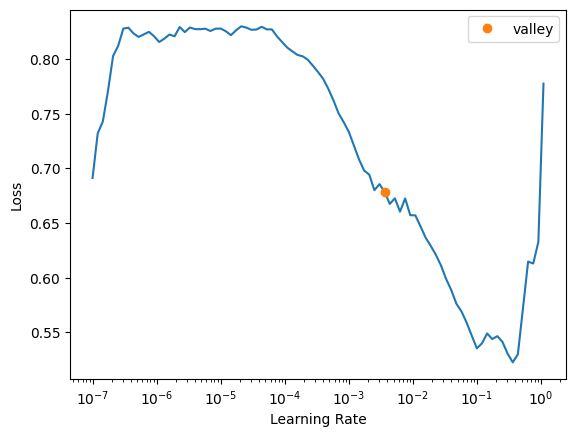

In [12]:
lr = learner.lr_find()
lr

Fine tune model for 3 epochs

In [13]:
learner.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.301464,0.187704,0.928975,0.917995,0.839583,0.877040,01:03


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.204679,0.145113,0.948460,0.969340,0.856250,0.909292,02:07
1,0.137127,0.073332,0.980515,0.957230,0.979167,0.968074,02:06
2,0.100383,0.061127,0.978630,0.956967,0.972917,0.964876,02:06


## Interpret results

F1-score (balanced score between Precision/Recall) is good and so are precision/recall. Note - the model was tuned using GPUs, tuning on CPUs will take significantly longer (hours).

Show a few predictions on training data.

In [14]:
learner.show_results()

,text,category,category_
0,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk - mail : xxunk : 03 - 3518 - xxunk",ham,spam
1,"xxbos "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct . xxmaj perhaps the most fundamental thing to realize about > life on xxmaj earth today . > > xxmaj the following is a fascinating document of official",ham,ham
2,"xxbos xxmaj this is a multi - part message in xxup mime format -- xxunk - d1b9 - 43d5 - xxunk - type : text / plain ; charset = gb2312content - transfer - encoding : quoted - printabledear xxunk fetch your name by xxunk month , our group had set up one xxup xxunk with xxmaj korean xxmaj xxunk xxmaj motors & = machinery xxunk company produces and distributes various whole motorcycle units =( xxunk ranging from xxunk to xxunk , including two - wheel motorcycle and three - wheel motorcycle , for carrying goods = and taking passengers ) and accessories especially main accessories of motorcycle , such as engine =( including xxunk , xxunk connecting rod , xxunk , engine xxunk head , xxunk body , clutch , = xxunk and xxunk rings ) , frame , fuel tank , shock absorber , disk xxunk , panels",spam,ham
3,"xxbos xxmaj from : xxunk xxrep 5 s xxunk : \t\t\t\t\t xxmaj subject : xxmaj earn money sending e - mails . xxmaj it 's easy ! \t▁ xxup new xxup improved xxunk friend , you can earn a lot of money in the next 90 days sending xxunk impossible ? xxmaj is there a catch ? xxup no , there is no catch ; justsend your e - mails and be on your way to financial freedom . xxmaj basically , i send out as many of these e - mails as i can , xxunk send me cash in the mail for information that i just e - xxunk to them . xxmaj everyday , i make a three minute drive to my xxup p.o . xxmaj xxunk that there are at least a few hundred dollars waiting forme . xxmaj and the best part , xxup it",spam,spam
4,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart_7hzmysbwvsemnjin8kg9ycontent - type : multipart / alternative ; \t boundary= "" xxrep 4 - = _ nextpart_7hzmysbwvsemnjin8kg9yaa "" xxrep 6 - = _ xxunk - type : text / html ; \t charset=""big5""content - transfer - encoding : xxunk xxrep 6 - = _ nextpart_7hzmysbwvsemnjin8kg9yaa xxrep 8 - = _ nextpart_7hzmysbwvsemnjin8kg9ycontent - type : application / octet - stream ; \t name= "" . / massmail-1509_files / xxunk - transfer - encoding : base64content - disposition : attachment ; \t xxunk xxrep 4 a xxunk xxrep 4 a xxunk xxrep 4 a xxmaj xxunk xxrep 4 a xxunk xxrep 4 a xxunk xxrep 3 a xxmaj ox xxrep 3 a xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk / xxunk",spam,spam
5,"xxbos i did more testing with your patch on top of today 's xxup cvs , but the xxunk help at all.the following is the results of the tests : testing xxunk . created a "" / dev / md0 "" with 4 scsi xxunk . created a xxup lvm xxmaj volume group "" vg "" with the "" / dev / xxunk . created a xxup lvm logical volume "" vol1 "" with "" xxunk . created a xxup xfs 

Plot confusion matrix. Note, the matrix is generated using the test data (20% of data data).

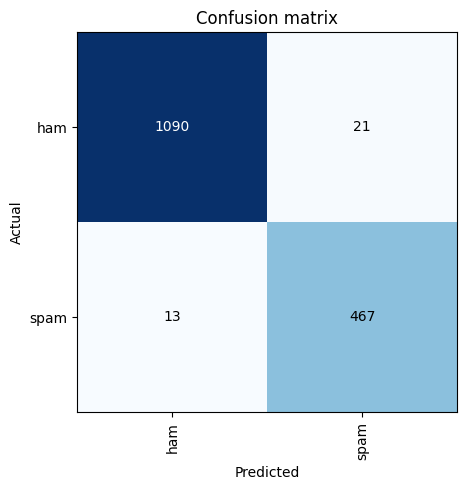

In [15]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

## Saving and loading model

In [16]:
learner.save('pretrained')

Path('models/pretrained.pth')

In [17]:
learner.load('pretrained')

# Language Model (ULMFiT approach)

The pretrained model in the previous section is called a language model. It was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before. We got great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better: the Wikipedia English is slightly different from the English in our email corpus. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the email corpus and then use that as the base for our classifier.

Create data loader for language modeling. Set aside 10% data using **RandomSplitter** for model validation.

In [19]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df(text_cols=('text'), 
                             is_lm=True),
    get_x=ColReader('text'), 
    splitter=RandomSplitter(valid_pct=0.1, seed=12345)
    ).dataloaders(df, bs=64)

In [20]:
dls_lm.show_batch(max_n = 10)

,text,text_
0,"xxbos [ jeremy ] > xxmaj the total collections are 1100 messages . i trained with 1100 / 5 > xxunk that 's not a lot of training data , i picked random subsets of xxunk and got much better behavior ( this is rates.py output ; f - p rate xxunk in left column , f - n rate in xxunk on xxmaj data / xxmaj ham / xxmaj set1 &","[ jeremy ] > xxmaj the total collections are 1100 messages . i trained with 1100 / 5 > xxunk that 's not a lot of training data , i picked random subsets of xxunk and got much better behavior ( this is rates.py output ; f - p rate xxunk in left column , f - n rate in xxunk on xxmaj data / xxmaj ham / xxmaj set1 & xxmaj"
1,"at : http : / / xxrep 3 w .europeaninternet.com / login / xxunk a partial list of current xxup ein subscribers can be found at : http : / / xxrep 3 w .europeaninternet.com / mediakit / xxmaj if you have any questions , comments , or need assistance signing up , please contact us personally by either writing to xxunk or simply replying to this email . xxmaj please feel",": http : / / xxrep 3 w .europeaninternet.com / login / xxunk a partial list of current xxup ein subscribers can be found at : http : / / xxrep 3 w .europeaninternet.com / mediakit / xxmaj if you have any questions , comments , or need assistance signing up , please contact us personally by either writing to xxunk or simply replying to this email . xxmaj please feel free"
2,": xxmaj no such file or directory xxmaj ca n't call method "" log "" on > unblessed reference at > / usr / local / lib / perl5 / site_perl / 5.8.0 / xxmaj razor2 / xxmaj client / xxmaj agent.pm line 212 . > > i have looked through the archived list and the only thing i have seen > about this error is a possible permission problem on the","xxmaj no such file or directory xxmaj ca n't call method "" log "" on > unblessed reference at > / usr / local / lib / perl5 / site_perl / 5.8.0 / xxmaj razor2 / xxmaj client / xxmaj agent.pm line 212 . > > i have looked through the archived list and the only thing i have seen > about this error is a possible permission problem on the log"
3,"up for games , classmates xxmaj personal xxmaj technology xxmaj teen handheld maker wants to play xxup rim files second suit against xxmaj good xxmaj gamers invade xxmaj army xxmaj web site & xxmaj the e - mail address for your subscription is & xxrep 10 q -zdnet@example.com xxmaj unsubscribe & | & xxmaj manage xxmaj my xxmaj subscriptions & | & xxup faq & | & xxmaj advertise xxmaj please send","for games , classmates xxmaj personal xxmaj technology xxmaj teen handheld maker wants to play xxup rim files second suit against xxmaj good xxmaj gamers invade xxmaj army xxmaj web site & xxmaj the e - mail address for your subscription is & xxrep 10 q -zdnet@example.com xxmaj unsubscribe & | & xxmaj manage xxmaj my xxmaj subscriptions & | & xxup faq & | & xxmaj advertise xxmaj please send any"
4,"over 300 , xxrep 3 0 search engines and directories \t every month . \t▁\t▁\t▁\t\t▁ & \t\t▁\t\t▁\t▁\t▁\t▁\t xxmaj you 'll be surprised by the low cost , and by how effective this website promotion \t method can be . \t▁\t xxmaj to find out more about trafficmagnet and the cost for submitting your website \t to over 300 , xxrep 3 0 search engines and directories , visit xxrep 3 w .trafficmagnet.com","300 , xxrep 3 0 search engines and directories \t every month . \t▁\t▁\t▁\t\t▁ & \t\t▁\t\t▁\t▁\t▁\t▁\t xxmaj you 'll be surprised by the low cost , and by how effective this website promotion \t method can be . \t▁\t xxmaj to find out more about trafficmagnet and the cost for submitting your website \t to over 300 , xxrep 3 0 search engines and directories , visit xxrep 3 w .trafficmagnet.com ."
5,"xxup begin xxup pgp xxup signature xxrep 5 - xxmaj version : xxunk / xxunk / xxunk m / xxunk xxrep 5 - xxup end xxup pgp xxup signature xxrep 76 - xxmaj the xxmaj libertarian xxmaj party http : / / xxrep 3 w .lp.org / 2600 xxmaj virginia xxmaj ave . xxup nw , xxmaj suite 100 voice : 202- xxrep 

Create text classifier learner. Use [AWD_LST]([https://paperswithcode.com/method/awd-lstm) model architecture.

For metrics, use Perplexity (lower is better: among how many words model is confused for predicting next word in sentence) for metrics.

In [21]:
lm_learner = language_model_learner(
            dls_lm, 
            AWD_LSTM, 
            wd=0.1,
            metrics=[Perplexity()]).to_fp16()

Find the optimal learning rate

SuggestedLRs(valley=0.0063095735386013985)

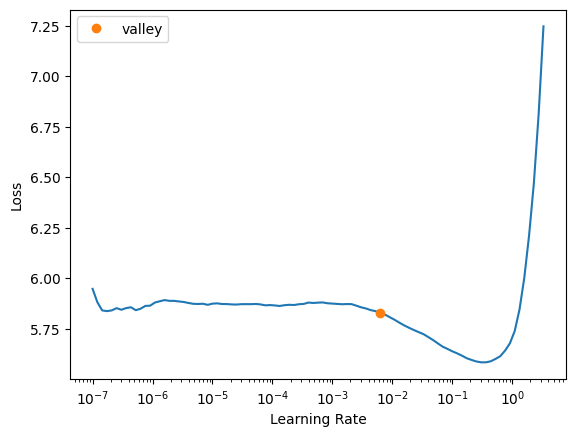

In [22]:
lr = lm_learner.lr_find()
lr

Fit one cycle - trains the new linear layer without changing the pre-trained layers, which remain frozen.

In [23]:
lm_learner.fit_one_cycle(1, lr[0])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.198651,3.790327,0.356320,44.270855,03:17


Save language model state.

In [24]:
lm_learner.save('1epoch')

Path('models/1epoch.pth')

Unfreeze all layers of model for futher tuning.

In [25]:
lm_learner.unfreeze()

SuggestedLRs(valley=0.00013182566908653826)

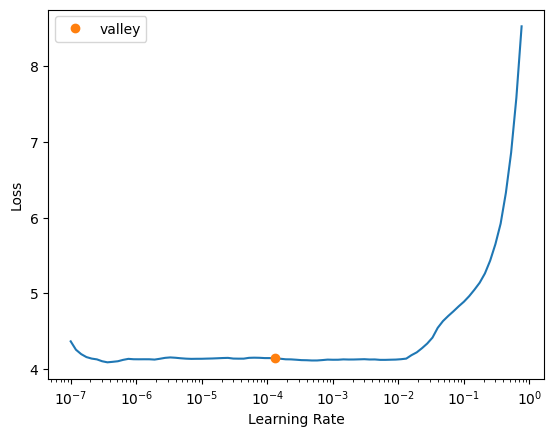

In [26]:
lr = lm_learner.lr_find()
lr

Train model for 5 epochs

In [27]:
lm_learner.fit_one_cycle(5, lr[0])

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.885533,3.622367,0.377741,37.426056,03:31
1,3.702563,3.468136,0.398056,32.076904,03:30
2,3.586781,3.378886,0.410035,29.338057,03:35
3,3.565593,3.340399,0.415442,28.230389,03:32
4,3.604337,3.333366,0.416273,28.032545,03:31


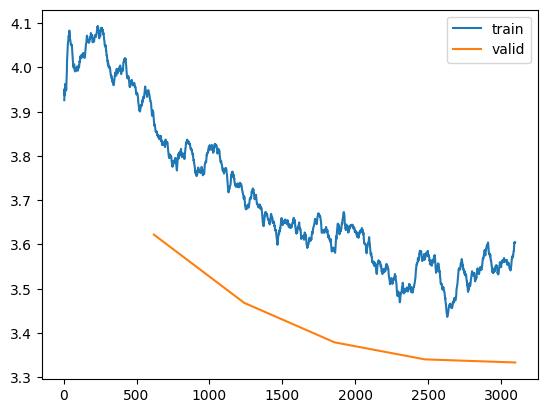

In [28]:
lm_learner.recorder.plot_loss()

Save fully tuned model.

In [29]:
lm_learner.save_encoder('finetuned')

Text generation

In [30]:
TEXT = "Free promotion"
N_WORDS = 40
N_SENTENCES = 5
preds = [lm_learner.predict(TEXT, N_WORDS, temperature=0.75)
for _ in range(N_SENTENCES)]
print("\n".join(preds))

Free promotion Free Software Software Software Jukebox Pro Jukebox 5 , The Best of the Downloads Jukebox 1 Asp.net Jukebox 15 Jukebox 4 Jukebox ! The
Free promotion to free trial on the Internet Archive List is subject to http : / / docs.yahoo.com / info / terms / On Thursday , October 27 , 2002 at 235 - 557 ,
Free promotion and promotion , and you 'll never have to receive further mailing lists . We do n't want anybody to receive our mailing who does n't wish to receive this mailing because they wish to receive further mailings .
Free promotion for Free Web Deterring Technologies will be available to you ! If you have not previously entered the web site , you may be wish to request for special offers . If you are
Free promotion to free software is available for free . That 's not a mess ! Why do n't worry about this ? Yes ! Thank you . They are within the top 50 in the world


Create DataLoaders for classification usng the cutomized language model.

In [31]:
dls_cls = DataBlock(
            blocks=(TextBlock.from_df(text_cols=('text'), 
                              is_lm=False, 
                              vocab=dls_lm.vocab), 
            CategoryBlock),
            get_x=ColReader('text'),
            get_y=ColReader('category'), 
            splitter=RandomSplitter(valid_pct=0.2, seed=12345)
            ).dataloaders(df, bs=64)

In [32]:
dls_cls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj this is a multi - part message in xxup mime format . xxrep 6 - = _ nextpart _ xxrep 3 0 _ xxrep 3 0 2_01c228ca.593b5280content - type : text / plain ; \t xxunk - xxunk - transfer - encoding : xxunk < xxunk xxrep 3 $ xxunk ! # xxunk ! # xxunk % / % xxunk , xxunk ! $ xxunk % / $ xxunk xxrep 3 $ xxunk , xxunk ! # xxunk : xxunk $ xxunk # ! xxunk xxrep 3 $ xxup xxunk / $ @$5$$ ! # ! xxunk / ! xxunk > xxunk $ / $ * 4j xxrep 5 $ ? $ 7$^$9 ! # xxunk xxrep 38 - + xxunk \ xxunk # % "" xxunk \ % xxunk # % xxunk ! e = xxunk xxunk - mail : xxunk : 03 - 3518 - xxunk",ham
1,"xxbos "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct . xxmaj perhaps the most fundamental thing to realize about > life on xxmaj earth today . > > xxmaj the following is a fascinating document of official",ham
2,"xxbos "" free trade and free markets have proven their ability to lift xxunk out of xxunk not a socio - political / history buff - does anybody have some xxunk ? xxrep 5 - xxmaj original xxmaj message xxrep 5 - xxmaj from : "" rohit xxmaj khare "" xxmaj to : xxmaj sent : xxmaj friday , xxmaj september 20 , 2002 xxunk pmsubject : sed / s / xxmaj united xxmaj states / xxmaj roman xxmaj empire / g > > a world where some live in comfort and plenty , while half of the human > > race lives on less than $ 2 a day , is neither just nor stable . > > xxmaj absolutely correct . xxmaj perhaps the most fundamental thing to realize about > life on xxmaj earth today . > > xxmaj the following is a fascinating document of official",ham


Create text classification learner.

In [33]:
learn = text_classifier_learner(dls_cls, 
                                AWD_LSTM, 
                                drop_mult=0.5, 
                                metrics=[accuracy, Precision(), Recall(), F1Score()])

In [34]:
learn = learn.load_encoder('finetuned')

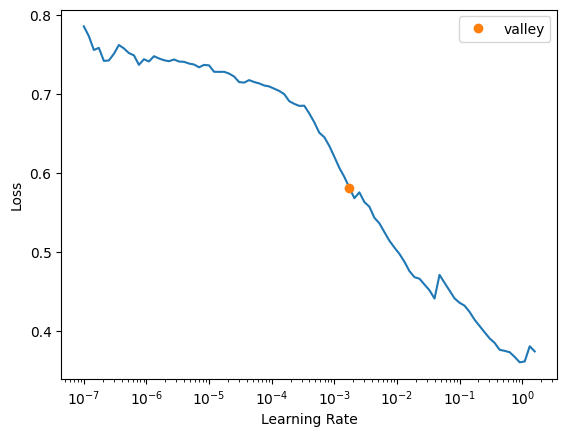

In [35]:
lr = learn.lr_find()

In [36]:
learn.fine_tune(3, lr[0])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.251876,0.110951,0.968553,0.936293,0.966135,0.950980,01:06


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.131474,0.067605,0.976730,0.965932,0.960159,0.963037,02:06
1,0.114329,0.055122,0.979874,0.966270,0.970120,0.968191,02:07
2,0.069277,0.051013,0.983019,0.968442,0.978088,0.973241,02:05


Plot confusion matrix. This ULMFit model has performed better (as expected) than the off-the-shelf pre-trained model.

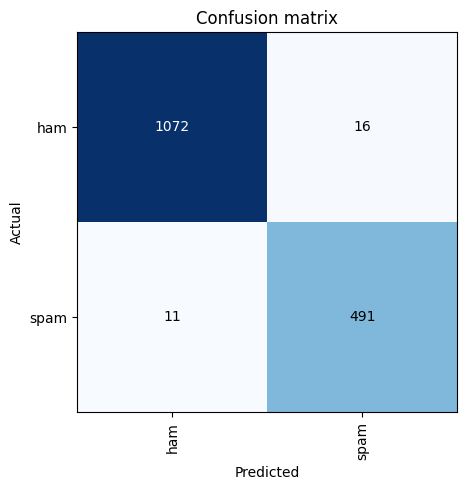

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()